In [7]:
import numpy as np

In [8]:
import pandas as pd

In [9]:
import seaborn as sns

In [10]:
import os

In [11]:
input_path = "../../input"

In [12]:
train_df = pd.read_csv(os.path.join(input_path, 'train/train.csv'))

In [13]:
test_df = pd.read_csv(os.path.join(input_path, 'test/test.csv'))

### Looking on label balance in dataset

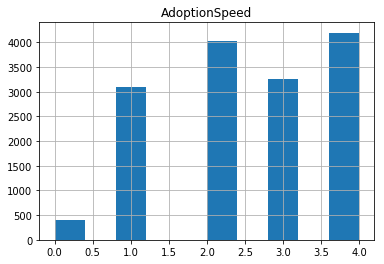

In [14]:
adoption_speed_hist = train_df.hist('AdoptionSpeed')

### Generate features based on 'Name' ('No_name',  'Bad_name')

In [15]:
train_df['Name'] = train_df['Name'].fillna('No Name')
test_df['Name'] = test_df['Name'].fillna('No Name')

In [16]:
train_df['No_name'] = 0
train_df.loc[(train_df['Name'] == 'No Name') | 
             (train_df['Name'] == 'No Name Yet'), 'No_name'] = 1
test_df['No_name'] = 0
test_df.loc[(test_df['Name'] == 'No Name')| 
             (test_df['Name'] == 'No Name Yet'), 'No_name'] = 1

In [17]:
train_df['Bad_name'] = 0
train_df.loc[train_df['Name'].apply(lambda x: len(str(x))) < 3, 'Bad_name'] = 1

In [18]:
test_df['Bad_name'] = 0
test_df.loc[test_df['Name'].apply(lambda x: len(str(x))) < 3, 'Bad_name'] = 1

### Generate simple (without words embeddings) features based on 'Description'

In [19]:
def add_text_length(df, text_column='Description'):
    df[text_column+'Length'] = df[text_column].fillna(" ").apply(lambda x: len(x))
    return df

In [20]:
def add_number_of_words(df, text_column='Description'):
    df['NumberOfWords'] = df[text_column].fillna(" ").apply(lambda x: len(x.split()))
    return df

In [21]:
def add_average_word_length(df, text_length_col='DescriptionLength', number_of_words_col='NumberOfWords'):
    
    df['AverageWordLength'] = df[text_length_col] / df[number_of_words_col]
    df['AverageWordLength'] = df['AverageWordLength'].replace([np.inf, -np.inf], 0)
    return df

In [22]:
def add_simple_text_features(df, text_column='Description'):
    df = add_text_length(df, text_column)
    df = add_number_of_words(df, text_column)
    df = add_average_word_length(df, 'DescriptionLength', 'NumberOfWords')
    return df

In [23]:
train_df = add_simple_text_features(train_df)

In [24]:
test_df = add_simple_text_features(test_df)

### Drop not-using features

In [26]:
# drop text features and hash id`s
drop_list = ['PetID', 
             'RescuerID', 
             'Description']

In [27]:
pet_id_test = test_df['PetID']

In [28]:
y = train_df['AdoptionSpeed']

In [29]:
X = train_df.drop(drop_list, axis=1)

In [30]:
# X = X.drop('AdoptionSpeed', axis=1)

In [31]:
X_test = test_df.drop(drop_list, axis=1)

### Select cat features

In [32]:
def get_column_indeces_from_names(df,name_list):
    indeces = []
    for name in name_list:
        indeces.append(df.columns.get_loc(name))
    return indeces

In [33]:
cat_feature_names = [
    'Type',
    'Breed1',
    'Breed2',
    'Gender',
    'Color1',
    'Color2',
    'Color3',
    'Vaccinated',
    'Dewormed',
    'Sterilized',
    'Health',
    'State',
    'No_name',
    'Bad_name'
]

### Create cd and pool

In [34]:
from catboost.utils import create_cd

In [35]:
label_index = X.columns.get_loc('AdoptionSpeed')

In [36]:
def make_feature_names_dict(df, label_name):
    columns = list(df.columns)
    columns.remove(label_name)
    column_indices = get_column_indeces_from_names(df, columns)
        
    return dict(zip(column_indices, columns))

In [37]:
X = X.drop(['Name', 'AdoptionSpeed'], axis=1)

In [38]:
X.head()

,Type,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,...,Quantity,Fee,State,VideoAmt,PhotoAmt,No_name,Bad_name,DescriptionLength,NumberOfWords,AverageWordLength
0,2,3,299,0,1,1,7,0,1,1,...,1,100,41326,0,1.0,0,0,359,69,5.202899
1,2,1,265,0,1,1,2,0,2,2,...,1,0,41401,0,2.0,1,0,118,23,5.130435
2,1,1,307,0,1,2,7,0,2,2,...,1,0,41326,0,7.0,0,0,393,69,5.695652
3,1,4,307,0,2,1,2,0,2,1,...,1,150,41401,0,8.0,0,0,146,25,5.840000
4,1,1,307,0,1,1,0,0,2,1,...,1,0,41326,0,3.0,0,0,390,81,4.814815


In [39]:
cat_features = get_column_indeces_from_names(X, cat_feature_names)

In [40]:
print(cat_features)

[0, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 19, 20]


In [41]:
from catboost import CatBoostClassifier, Pool

In [42]:
from sklearn.model_selection import train_test_split

In [43]:
X_train, X_valid, y_train, y_valid = train_test_split(X,
                                                        y, 
                                                        train_size=0.8,
                                                        stratify=y
    )

/home/roman-baldaev/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [44]:
pool_train = Pool(data=X_train,
                 label=y_train,
                 cat_features=cat_features)

In [45]:
pool_valid = Pool(data=X_valid,
                 label=y_valid,
                 cat_features=cat_features)

In [46]:
(pool_train.shape, pool_valid.shape)

((11994, 24), (2999, 24))

In [47]:
clf = CatBoostClassifier(iterations=200,
                            loss_function = 'MultiClass',
                            depth=4,
                            leaf_estimation_iterations = 20,
                            use_best_model=True,
                            classes_count=5
    )

In [ ]:
clf.fit(pool_train,
            logging_level='Verbose',
            eval_set=pool_valid
    )

0:	learn: -1.5967399	test: -1.5968562	best: -1.5968562 (0)	total: 277ms	remaining: 55s
1:	learn: -1.5850591	test: -1.5853066	best: -1.5853066 (1)	total: 595ms	remaining: 58.9s
2:	learn: -1.5743181	test: -1.5747055	best: -1.5747055 (2)	total: 947ms	remaining: 1m 2s
3:	learn: -1.5641160	test: -1.5644296	best: -1.5644296 (3)	total: 1.46s	remaining: 1m 11s
4:	learn: -1.5545272	test: -1.5550345	best: -1.5550345 (4)	total: 1.77s	remaining: 1m 9s
5:	learn: -1.5450461	test: -1.5456701	best: -1.5456701 (5)	total: 2.13s	remaining: 1m 8s
6:	learn: -1.5373052	test: -1.5380406	best: -1.5380406 (6)	total: 2.44s	remaining: 1m 7s
7:	learn: -1.5300968	test: -1.5307595	best: -1.5307595 (7)	total: 2.71s	remaining: 1m 5s
8:	learn: -1.5234879	test: -1.5242569	best: -1.5242569 (8)	total: 2.98s	remaining: 1m 3s
9:	learn: -1.5174090	test: -1.5182684	best: -1.5182684 (9)	total: 3.27s	remaining: 1m 2s
10:	learn: -1.5106767	test: -1.5116514	best: -1.5116514 (10)	total: 3.64s	remaining: 1m 2s
11:	learn: -1.505473

91:	learn: -1.3800499	test: -1.3869814	best: -1.3869814 (91)	total: 32.4s	remaining: 38s
92:	learn: -1.3795163	test: -1.3865157	best: -1.3865157 (92)	total: 32.7s	remaining: 37.7s
93:	learn: -1.3792573	test: -1.3863259	best: -1.3863259 (93)	total: 33.1s	remaining: 37.3s
94:	learn: -1.3791515	test: -1.3862153	best: -1.3862153 (94)	total: 33.4s	remaining: 36.9s
95:	learn: -1.3784556	test: -1.3856708	best: -1.3856708 (95)	total: 33.8s	remaining: 36.6s
96:	learn: -1.3781040	test: -1.3853129	best: -1.3853129 (96)	total: 34.2s	remaining: 36.3s
97:	learn: -1.3778282	test: -1.3850547	best: -1.3850547 (97)	total: 34.5s	remaining: 35.9s
98:	learn: -1.3774680	test: -1.3847371	best: -1.3847371 (98)	total: 34.9s	remaining: 35.6s
99:	learn: -1.3771588	test: -1.3844377	best: -1.3844377 (99)	total: 35.2s	remaining: 35.2s
100:	learn: -1.3768447	test: -1.3840746	best: -1.3840746 (100)	total: 35.6s	remaining: 34.9s
101:	learn: -1.3766107	test: -1.3839063	best: -1.3839063 (101)	total: 35.9s	remaining: 34.

In [ ]:
X_test = X_test.drop(['Name'], axis=1)

In [ ]:
pred_test = clf.predict(X_test)

In [ ]:
pred = list(map(lambda x: int(x[0]), pred_test))

In [ ]:
submit_df = pd.DataFrame(data={'PetID': pet_id_test, 'AdoptionSpeed': pred})

In [ ]:
submit_target_hist = submit_df.hist('AdoptionSpeed')

In [ ]:
submit_df.head()

In [247]:
submit_df.to_csv('submission.csv', index=False)